Библиотеки и подключение к диску

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import numpy as np
import pydicom as dc
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os, glob
#from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Создаем .npy массивы из изображений и разметок 

In [ ]:
train_names = sorted(glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/train/train/DICOM/*"))
test_names = sorted(glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/test/test/DICOM/*"))
label_names = sorted(glob.glob("/content/drive/MyDrive/Colab Notebooks/unet/train/train/Label/*"))

train_ds = []
test_ds = []
y_train = []

for name in train_names:
    train_ds.append(dc.dcmread(name))
for name in test_names:
    test_ds.append(dc.dcmread(name))
for label_name in label_names:
    img = Image.open(label_name)
    y_train.append(np.asarray(img))
y_train = np.asarray(y_train)

# Новый раздел

In [ ]:
X_train = []
X_test = []
for sample_ds in train_ds:
    X_train.append(sample_ds.pixel_array)
for sample_ds in test_ds:
    X_test.append(sample_ds.pixel_array)
X_train = np.asarray(X_train).astype(float)
X_test = np.asarray(X_test).astype(float)

При необходимости сохраняем.

In [ ]:

np.save('/content/drive/MyDrive/Colab Notebooks/unet/x_train.npy', X_train)
np.save('/content/drive/MyDrive/Colab Notebooks/unet/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Colab Notebooks/unet/x_val.npy', X_test)


Для представления в каких пределах находится градация серого. Для данной задачи все, что меньше -1000 HU это вохдух или дефекты - они не  нтересны поэтому обрезаем. Около 700 HU это кости, выше уже ничего изображалось. Так как большая часть это фон ~(<-1000), а все остально жир или мягкия ткани в пределах -100 до 200, то приводить к [0, 1] плохая идея(как и оказалось в исследовании). Поэтому приводилось к нормальному распредлению. 

In [ ]:

import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [ ]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    img = img.astype("float64")
    img[img > 700] = 700
    img[img < -1000] = -1000
    return img

In [ ]:
def sample_stack(stack, rows=6, cols=6, start_with=1, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

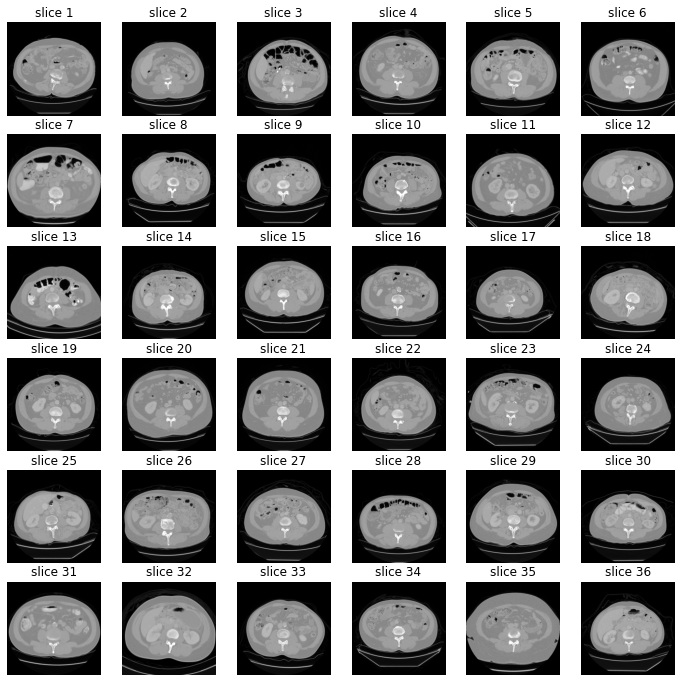

In [ ]:
masked_lung = []
for img in X_test:
    make_lungmask(img)
for img in X_train:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=1)

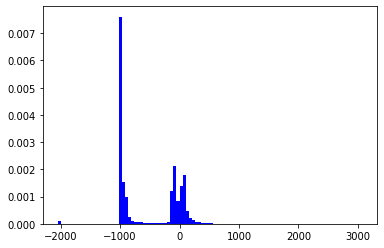

In [ ]:
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)
plot_hists(X_train)


Нормализация, добавление канала к изабражениям, деление на тренировочную и валидационную выборку и категориализация разметок.

In [ ]:
import keras
from keras.utils.np_utils import normalize

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)
y_train = np.expand_dims(y_train, axis=3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.30, random_state = 0)

In [ ]:
n_classes = 4
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=n_classes)
#y_train = y_train_ctg.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

y_val = to_categorical(y_val, num_classes=n_classes)
#y_val = y_val_ctg.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

Модель U-net. На 2-3 слоях внутренности перемешивались, поэтому решено было остаться на двух. Добавлен dropuot для препятствования переобучения. 

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, BatchNormalization

def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    conv1_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    #conv1_1 = BatchNormalization(axis=1)(conv1_1)
    drop1 = Dropout(0.2)(conv1_1)
    conv1_2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop1)
    pool1 = MaxPooling2D((2, 2))(conv1_2)
    
    conv2_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    #conv2_1 = BatchNormalization(axis=1)(conv2_1)
    #conv2_1 = Dropout(0.3)(conv2_1)
    conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2_1)
    pool2 = MaxPooling2D((2, 2))(conv2_2)
     
    conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    #conv3_1 = BatchNormalization(axis=1)(conv3_1)
    #conv3_1 = Dropout(0.4)(conv3_1)
    conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3_1)
    pool3 = MaxPooling2D((2, 2))(conv3_2)
     
    conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    #conv4_1 = BatchNormalization(axis=1)(conv4_1)
    #conv4_1 = Dropout(0.4)(conv4_1)
    conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4_1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_2)
     
    conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    #conv5_1 = BatchNormalization(axis=1)(conv5_1)
    drop5 = Dropout(0.5)(conv5_1)
    conv5_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop5)

    up_trans6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5_2)
    up_conc6 = concatenate([up_trans6, conv4_2])
    up_conv6_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up_conc6)
    #up_conv6_1 = BatchNormalization(axis=1)(up_conv6_1)
    drop6 = Dropout(0.4)(up_conv6_1)
    up_conv6_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop6)
     
    up_trans7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up_conv6_2)
    up_conc7 = concatenate([up_trans7, conv3_2])
    up_conv7_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up_conc7)
    #up_conv7_1 = BatchNormalization(axis=1)(up_conv7_1)
    drop7 = Dropout(0.4)(up_conv7_1)
    up_conv7_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop7)
     
    up_trans8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(up_conv7_2)
    up_conc8 = concatenate([up_trans8, conv2_2])
    up_conv8_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up_conc8)
    drop8 = Dropout(0.3)(up_conv8_1)
    #drop8 = BatchNormalization(axis=1)(drop8)
    up_conv8_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop8)
     
    up_trans9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(up_conv8_2)
    up_conc9 = concatenate([up_trans9, conv1_2])
    up_conv9_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up_conc9)
    #up_conv9_1 = BatchNormalization(axis=-1)(up_conv9_1)
    drop9 = Dropout(0.2)(up_conv9_1)
    up_conv9_2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(up_conv9_2)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model
 

В силу малого количетсва тренировочных данных делаем height_shift_range(в пределах 50 вверх-вниз), rotation_range(5-10) и horizontal_flip(симметрия допустима). vertical_flip(так не снимают КТ), width_shift_range(срез близок к изображению), zoom_range(срез близок к изображению), share_range(таких КТ не будет) для КТ плохи.
Если добавлять все, то идет переобучение и скачки по точности.

In [ ]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

x_gen = dict(rotation_range= 15,
             height_shift_range=0.15,
             width_shift_range = 0.3,
             shear_range = 0.3,
             zoom_range=0.2,
             horizontal_flip=True,
             fill_mode='nearest')

y_gen = dict(rotation_range= 15,
             height_shift_range=0.15,
             width_shift_range = 0.3,
             shear_range = 0.3,
             zoom_range=0.2,
             horizontal_flip=True,
             fill_mode='nearest')

batch_size= 4

x_generator = ImageDataGenerator(**x_gen)
x_generator.fit(X_train, augment=True, seed=seed)
test_x_generator = x_generator.flow(X_train, seed=seed, batch_size=batch_size)
val_x_generator = x_generator.flow(x_val, seed=seed, batch_size=batch_size)

y_generator = ImageDataGenerator(**y_gen)
y_generator.fit(y_train, augment=True, seed=seed)
test_y_generator = y_generator.flow(y_train, seed=seed, batch_size=batch_size)
val_y_generator = y_generator.flow(y_val, seed=seed, batch_size=batch_size)

def generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

test_x_y_generator = generator(test_x_generator, test_y_generator)

val_x_y_generator = generator(val_x_generator, val_y_generator)

In [ ]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/Colab Notebooks/unet/saved_models_4/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Adam, Nadam, Adamax, RMSprop хороши. SGD, Adagrad выше 70% не поднимались. 

In [ ]:
def get_model():
    return multi_unet_model(n_classes = 4, IMG_HEIGHT = 512, IMG_WIDTH = 512, IMG_CHANNELS = 1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()

steps_per_epoch = 3*(len(X_train))//batch_size
history = model.fit_generator(test_x_y_generator, validation_data=val_x_y_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch,
                    callbacks=[checkpoint], epochs=80)
_, acc = model.evaluate(x_val, y_val)
print("Accuracy is = ", (acc * 100.0), "%")

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 512, 512, 16  160         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_57 (Dropout)           (None, 512, 512, 16  0           ['conv2d_152[0][0]']             
                                )                                                           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 1.2561 - accuracy: 0.4243
Epoch 1: val_loss improved from inf to 0.82721, saving model to /content/drive/MyDrive/Colab Notebooks/unet/saved_models_4/weights-improvement-01-0.83.hdf5
21/21 [==============================] - 25s 1s/step - loss: 1.2561 - accuracy: 0.4243 - val_loss: 0.8272 - val_accuracy: 0.5846
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.6832
Epoch 2: val_loss improved from 0.82721 to 0.58398, saving model to /content/drive/MyDrive/Colab Notebooks/unet/saved_models_4/weights-improvement-02-0.58.hdf5
21/21 [==============================] - 20s 989ms/step - loss: 0.6434 - accuracy: 0.6832 - val_loss: 0.5840 - val_accuracy: 0.7726
Epoch 3/80
21/21 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7637

Сохраняем, если нужно модель

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/unet/version1.3.2.7.hdf5')

Строим графики потерь и точности.

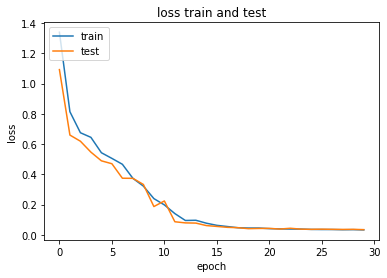

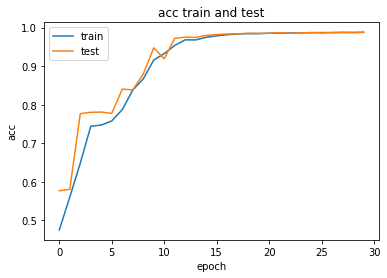

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss train and test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('acc train and test')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Можно загрузить модель и посмотреть точность по классам

In [ ]:
from keras.models import load_model
model_loaded = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/unet/saved_models_3/weights-improvement-62-0.04.hdf5')
y_pred=model_loaded.predict(x_val)
y_pred_argmax=np.argmax(y_pred, axis=3)

from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
y_val_argmax = np.argmax(y_val, axis = 3)
IOU_keras.update_state(y_val_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


acc_classes = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(acc_classes)
acc_class1 = acc_classes[0,0]/(acc_classes[0,0] + acc_classes[0,1] + acc_classes[0,2] + acc_classes[0,3] + acc_classes[1,0]+ acc_classes[2,0]+ acc_classes[3,0])
acc_class2 = acc_classes[1,1]/(acc_classes[1,1] + acc_classes[1,0] + acc_classes[1,2] + acc_classes[1,3] + acc_classes[0,1]+ acc_classes[2,1]+ acc_classes[3,1])
acc_class3 = acc_classes[2,2]/(acc_classes[2,2] + acc_classes[2,0] + acc_classes[2,1] + acc_classes[2,3] + acc_classes[0,2]+ acc_classes[1,2]+ acc_classes[3,2])
acc_class4 = acc_classes[3,3]/(acc_classes[3,3] + acc_classes[3,0] + acc_classes[3,1] + acc_classes[3,2] + acc_classes[0,3]+ acc_classes[1,3]+ acc_classes[2,3])

print("accuracy for class1 is: ", acc_class1)
print("accuracy for class2 is: ", acc_class2)
print("accurace for class3 is: ", acc_class3)
print("accuracy for class4 is: ", acc_class4)

Mean IoU = 0.9608048
[[1.759139e+06 0.000000e+00 0.000000e+00 3.494000e+03]
 [0.000000e+00 6.253600e+05 1.217600e+04 4.000000e+00]
 [0.000000e+00 7.302000e+03 3.531270e+05 4.653000e+03]
 [3.867000e+03 0.000000e+00 5.482000e+03 3.711240e+05]]
accuracy for class1 is:  0.995833
accuracy for class2 is:  0.96978796
accurace for class3 is:  0.92262894
accuracy for class4 is:  0.95496935


In [ ]:
y_pred=model.predict(x_val)
y_pred_argmax=np.argmax(y_pred, axis=3)

from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
y_val_argmax = np.argmax(y_val, axis=3)
IOU_keras.update_state(y_val_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


acc_classes = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(acc_classes)
acc_class1 = acc_classes[0,0]/(acc_classes[0,0] + acc_classes[0,1] + acc_classes[0,2] + acc_classes[0,3] + acc_classes[1,0]+ acc_classes[2,0]+ acc_classes[3,0])
acc_class2 = acc_classes[1,1]/(acc_classes[1,1] + acc_classes[1,0] + acc_classes[1,2] + acc_classes[1,3] + acc_classes[0,1]+ acc_classes[2,1]+ acc_classes[3,1])
acc_class3 = acc_classes[2,2]/(acc_classes[2,2] + acc_classes[2,0] + acc_classes[2,1] + acc_classes[2,3] + acc_classes[0,2]+ acc_classes[1,2]+ acc_classes[3,2])
acc_class4 = acc_classes[3,3]/(acc_classes[3,3] + acc_classes[3,0] + acc_classes[3,1] + acc_classes[3,2] + acc_classes[0,3]+ acc_classes[1,3]+ acc_classes[2,3])

print("accuracy for class1 is: ", acc_class1)
print("accuracy for class2 is: ", acc_class2)
print("accurace for class3 is: ", acc_class3)
print("accuracy for class4 is: ", acc_class4)

Mean IoU = 0.9610437
[[1.759285e+06 0.000000e+00 0.000000e+00 3.348000e+03]
 [0.000000e+00 6.269670e+05 1.052700e+04 4.600000e+01]
 [0.000000e+00 9.081000e+03 3.500720e+05 5.929000e+03]
 [3.893000e+03 0.000000e+00 3.871000e+03 3.727090e+05]]
accuracy for class1 is:  0.995901
accuracy for class2 is:  0.9696051
accurace for class3 is:  0.9225045
accuracy for class4 is:  0.95616424


Можно посмотреть результат для валидации и тестирования

In [ ]:

preds = model_loaded.predict(x_val)
y_pred_argmax=np.argmax(preds, axis=3)
X_c_train = np.argmax(x_val, axis=1)
nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(8), fig.set_figwidth(8 * ncols // nrows)
for i, (X, y) in enumerate(zip(X_c_train, y_pred_argmax)):
    if i == nrows * ncols // 2:
        break
    ax[2 * i // ncols, 2 * i % ncols].imshow(X)
    ax[(2 * i + 1) // ncols, (2 * i + 1) % ncols].imshow(y)

NameError: ignored

Точность, предоставленная в блокноте.

In [ ]:
def one_hot_encode(arr, num_classes=4):
    return np.squeeze(np.eye(num_classes)[arr.reshape(-1)]).astype(np.uint8)


def dice(y_pred, y_true):
    gto = one_hot_encode(y_true)
    mo = one_hot_encode(y_pred)
    intersect = (gto * mo).sum()
    total = (gto + mo).sum()
    return np.mean(2. * intersect / (total + 1e-10))


pred = np.argmax(y_val, axis=3)

dice(y_pred_argmax, pred)

0.9882450103759766

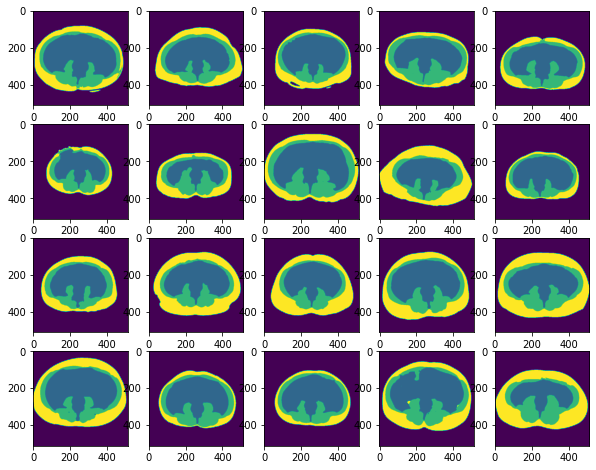

In [ ]:
#model_loaded = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/unet/version1.2.9.7.hdf5')
preds = model_loaded.predict(X_test)
y_pred_argmax=np.argmax(preds, axis=3)
nrows, ncols = 4 , 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(8), fig.set_figwidth(8 * ncols // nrows)
for i, X in enumerate(y_pred_argmax):
    if i == nrows * ncols:
        break
    ax[i // ncols, i % ncols].imshow(X)

Сохраняем полученные маски в csv file

In [ ]:
def rle_encoding(mask):
        dots = np.where(mask.T.flatten()==1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1): run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths    


def write_submission(y):
    df = pd.DataFrame(columns=['ImageID', 'EncodedPixels'])
    for i, mask in enumerate(y):
        mask1 = (mask == 1).astype(int)
        mask2 = (mask == 2).astype(int)
        mask3 = (mask == 3).astype(int)
        df.loc[3 * i] = [str(3 * i), ""]
        df.loc[3 * i + 1] = [str(3 * i + 1), ""]
        df.loc[3 * i + 2] = [str(3 * i + 2), ""]
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask1)])
        df.loc[3 * i]['EncodedPixels'] = encoded_mask
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask2)])
        df.loc[3 * i + 1]['EncodedPixels'] = encoded_mask
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask3)])
        df.loc[3 * i + 2]['EncodedPixels'] = encoded_mask
    return df


df = write_submission(y_pred_argmax)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/unet/submission3.3.csv', index=False)
df.shape

(60, 2)